In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

In [2]:
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import itertools
from functools import partial
from multiprocessing import Pool
from sklearn.metrics import roc_curve, auc
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
sns.set_palette("Set2")
import functions
from Bio.SeqUtils.ProtParam import ProteinAnalysis


%load_ext autoreload
%autoreload 2


# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}


#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}

scales = [v for k, v in kd.items()]
index=[k for k, v in kd.items()]

feat = ['GRAVY', 'Flexibility', 'Helix','SWI',  'Sheet',\
            'Instability index', 'Turn',  'Aromaticity',\
            'Isoelectric point',\
            ]

In [3]:
def gravy(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.gravy()
    except Exception:
        g = np.nan
    return g

def flex(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = np.mean(anlys.flexibility())
    except Exception:
        g = np.nan
    return g


def helix(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.secondary_structure_fraction()[0]
    except Exception:
        g = np.nan
    return g

def turn(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.secondary_structure_fraction()[1]
    except Exception:
        g = np.nan
    return g

def sheet(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.secondary_structure_fraction()[2]
    except Exception:
        g = np.nan
    return g


def insta(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.instability_index()
    except Exception:
        g = np.nan
    return g

def iso(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.isoelectric_point()
    except Exception:
        g = np.nan
    return g

def aroma(seq):
    anlys = ProteinAnalysis(seq)
    try:
        g = anlys.aromaticity()
    except Exception:
        g = np.nan
    return g

def helper(df, feat):
    df = df.copy()
#     df['Analysed_seq'] = df['Protein_'].apply(ProteinAnalysis)
    if feat == 'GRAVY':
        df['GRAVY'] = df['Protein_'].apply(gravy)
    if feat == 'Flexibility':
        df['Flexibility'] = df['Protein_'].apply(flex)
    if feat == 'Instability index':
        df['Instability index'] = df['Protein_'].apply(insta)
    if feat == 'Isoelectric point':
        df['Isoelectric point'] = df['Protein_'].apply(iso)

    if feat == 'Helix':
        #separate sec str in helix turn sheets
        df['Helix'] = df['Protein_'].apply(helix)
    if feat == 'Turn':
        df['Turn'] = df['Protein_'].apply(turn)
    if feat == 'Sheet':
        df['Sheet'] = df['Protein_'].apply(sheet)
    if feat == 'Aromaticity':
        df['Aromaticity'] = df['Protein_'].apply(aroma)
    if feat == 'SWI':
        df['SWI'] = df['Protein_'].apply(functions.swi)
    
    return df

In [5]:

def heatmap(df, a):

    #all combination of regions
    #we take inital sixty
    all_comb = list(itertools.combinations(np.arange(0, 61), 2))

    test_df = pd.DataFrame(columns=np.arange(1, 62), index=np.arange(1, 62))
    for i, v in enumerate(all_comb):
        df['Protein_'] = df['Protein'].str[v[0]:v[1]]
        df = helper(df, a)
        df_roc = df[[a, 'Label']].copy()
        df_roc.dropna(inplace=True)

        labels = df_roc['Label'].values
        preds = df_roc[a].values

        try:
            fpr, tpr, _ = roc_curve(labels, preds)
            roc_auc = auc(fpr, tpr)
            if roc_auc < 0.5:
                roc_auc = 1 - roc_auc
        except Exception:
            roc_auc = np.nan
        test_df.loc[v[0]+1, v[1]] = roc_auc
#         functions.progress(i+1, len(all_comb), a)
    return test_df
    

def compute(df, index):
    pools = Pool(len(index))
    cost_func = partial(heatmap, df)
    results = []
    for result in pools.imap(cost_func,  index):
        results.append(result)
        functions.progress(len(results), len(index))
    pools.close()
    pools.join()
    
    return results

def export_results(results, name):
    converted = [i.astype(float) for i in results]
    all_results = pd.DataFrame({'AUC':converted}, index=feat)
    all_results.to_pickle('results/AUC_Heatmap_features{}.pkl.gz'.format(name))
    return all_results

def return_max(df):
    max_val = max(df.fillna(0.5).values.flatten())
    x = 0
    y = 0
    try:
        for i, v in enumerate(df.columns):
            if max_val in df[v].values:
                y = v
        for i, v in enumerate(df[y]):
            if v == max_val:
                x = i + 1
        return max_val, x, y
    except Exception:
        return 0, 0, 0



def plot_heatmap(results, name):
    
#     #Sort results by hydrophobicity
#     hydrophobicity = pd.DataFrame({'Hydrophobicity':scales}, index=index)

#     all_aucs__ = results.join(hydrophobicity).sort_values(by='Hydrophobicity').copy()
    all_auc = results[['AUC']].copy()
    
    all_aa_aucs = all_auc['AUC'].values
    all_aa = all_auc.index

    sns.set_context("paper", font_scale=1.6)
    fig, axn = plt.subplots(nrows=2, ncols=5, figsize=(9, 4), sharey=True, sharex=True)
    cbar_ax = fig.add_axes([1, .2, .01, .65])

    for i, ax in enumerate(axn.flat):
        if i <= 8:

            max_auc_val, x, y = return_max(all_aa_aucs[i])
            sns.heatmap(all_aa_aucs[i].loc[:60, :60], ax=ax,
                        cbar=i == 0,
                        vmin=0.5, vmax=0.95,
                        cbar_ax=None if i else cbar_ax,
                        cmap='viridis',)
            ax.invert_yaxis()

            if max_auc_val <= 0.6:
                color = "white"
            else:
                color="black"

            ax.annotate('AUC = ' + str(round(max_auc_val, 2)) + '\n(' + str(x) + ':' + str(y) + ')',
                    xy=(y, x), xycoords='data',
                    xytext=(0.4, 0.7), textcoords='axes fraction',
                    horizontalalignment="center",
                    fontsize=12,
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    color=color,
                                    lw=1.5),
                    )



            ax.set_title(all_aa[i])
            plt.sca(ax)
            plt.xticks([ 0.5, 29.3, 57.76],\
                       [1,  30, 60],)
            plt.yticks([ 0.5, 29.3, 57.76],\
                       [1, 30, 60],)

    fig.text(0.5, -0.04, 'Amino acid position', ha='center')
    fig.text(-0.005, 0.5, 'Amino acid position', va='center', rotation='vertical')
    fig.tight_layout(rect=[0, 0, 1, 1])

    plt.savefig('figs/Generic_AUC_matrix_feature{}.pdf'.format(name),  bbox_inches='tight', pad_inches=0)
    plt.show()


In [6]:
df = pd.read_pickle('results/signalp5_train_all.pkl.gz')
df.head(2)

,Entry,All,Protein,Entry name,Status,Protein names,Gene names,Organism,Length,Signal peptide,...,Cross-reference (Pfam),Biotechnological use,Motif,Domain [FT],Cross-reference (InterPro),Cross-reference (PROSITE),Cleavage,Accession,Label,Aligned
0,Q92791,sp|Q92791|SC65_HUMAN Endoplasmic reticulum pro...,MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAAYGHALEQ...,SC65_HUMAN,reviewed,Endoplasmic reticulum protein SC65 (Leprecan-l...,P3H4 LEPREL4 NOL55 SC65,Homo sapiens (Human),437,"SIGNAL 1..18; /evidence=""ECO:0000255""",...,NaN,NaN,NaN,NaN,IPR033213;,NaN,18.0,Q92791|EUKARYA|NO_SP|1,1,__MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAA
1,B0JFB8,sp|B0JFB8|FPI1_ANTMY Fungal protease inhibitor...,MKAVITLLFLACILVVTYGDLICGTNYCKDHPCTSPIARASCRSPA...,FPI1_ANTMY,reviewed,Fungal protease inhibitor-1,fpi-1,Antheraea mylitta (Tasar silkworm),105,"SIGNAL 1..19; /evidence=""ECO:0000269|PubMed:1...",...,PF12190;,NaN,NaN,NaN,IPR021066;,NaN,19.0,B0JFB8|EUKARYA|SP|0,1,_MKAVITLLFLACILVVTYGDLICGTNYCKDHPCTSPIARA


In [7]:
from subprocess import run, PIPE, DEVNULL

kingdoms = ['Eukaryota', ]
dfs = []
for i, v in enumerate(kingdoms):
    #Cluster
    s = df[df['Taxonomic lineage (SUPERKINGDOM)'].apply(lambda x: x == v)].copy()

    cl = s[['Entry', 'Protein']].copy()
    cl['Entry'] = '>' + cl['Entry']
    cl['Protein'] = cl['Protein'].str[:60]
    
    fname = 'results/{}.fa'.format(kingdoms[i])
    clust_fname = 'results/{}_cluster.fa'.format(kingdoms[i])
    cl.to_csv(fname, sep='\n', index=None, header=None)

    all_args = ['cd-hit', '-i', fname, '-o', clust_fname, '-n', '5', '-c', '0.7']

    run(all_args, stdout=PIPE, stderr=DEVNULL, encoding='utf-8')

    clustered = functions.fasta_reader(clust_fname)
    
    new_df = s[s['Entry'].apply(lambda x: x in clustered.Accession.values)]
    new_df = new_df.reset_index(drop=True)
    
    
    dfs.append(new_df)
#     dfs.append(s.copy())

for p, q in enumerate(dfs):
    print(kingdoms[p]+'\n----------')
    print(q.Label.value_counts())
    print('---------')

Eukaryota
----------
0    13237
1     1964
Name: Label, dtype: int64
---------


In [8]:
toxins = pd.read_pickle('results/toxin_nontoxin.pkl.gz')


dfs.append(toxins)
kingdoms.append('Toxins') #Not kingdom but whatever

toxins.Label.value_counts()

0    1738
1     261
Name: Label, dtype: int64

Eukaryota 


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


|██████████████████████████████████████████████████| 100% (9/9)  
Completed!


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


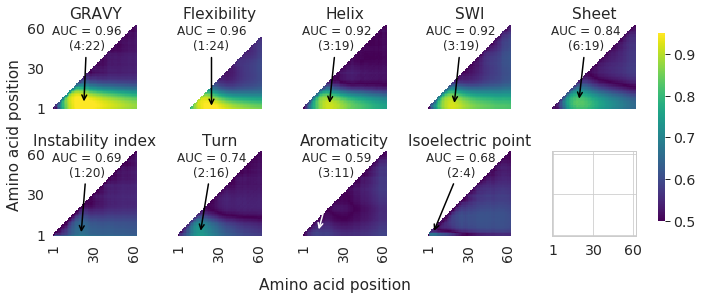


Toxins 


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


|██████████████████████████████████████████████████| 100% (9/9)  
Completed!


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


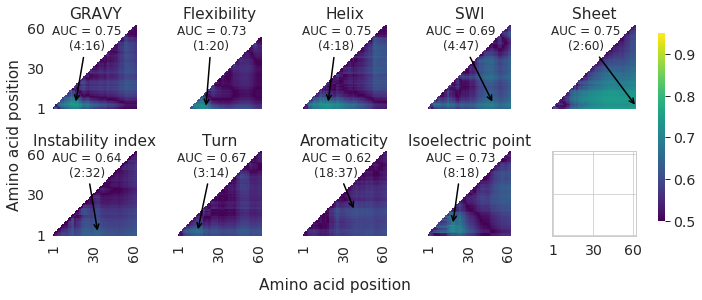

In [9]:

for i, k in enumerate(kingdoms):
    print(k+ ' \n'+"=============")
    d = dfs[i]
    results = compute(d, feat)
    all_auc_df = export_results(results, k)
    plot_heatmap(all_auc_df, k)
    print('=============\n')